# BERT
### Bidirectional Encoder Representations from Transformers
Why BERT?

BERT encodes the words before and after the selected word, hence retaining more context of the sentence. 

BERT also makes use of masking (hiding 15% of words), thus the model is better able to predict words within a sentence.

BERT also makes use of transformer's attention mechanism, enabling the model to have longer memory and retain context from previous tokens.



# Import required libraries
- Download pre-trained model from tensorflow hub

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)

In [7]:
!pip install sentencepiece

In [8]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [9]:
import tensorflow_hub as hub
import tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

# Data Cleaning
Firstly, we will split all the reviews into sentences.

In [10]:
# split into sentences
df = pd.read_csv('reviews.csv')
df['comments'] = df['comments'].astype(str)
df['sentences'] = df['comments'].apply(lambda x: x.split('.'))
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentences
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,"[Cute and cozy place, Perfect location to eve..."
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,[Kelly has a great room in a very central loca...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...","[Very spacious apartment, and in a great neigh..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,[Close to Seattle Center and all it has to off...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,[Kelly was a great host and very accommodating...


In [11]:
# make each sentence into its own row
s = df.apply(lambda x: pd.Series(x['sentences']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'sentence'
df = df.drop('sentences', axis=1).join(s)
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,Cute and cozy place
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,Perfect location to everything!
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,Kelly has a great room in a very central location
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,"\r\nBeautiful building , architecture and a s..."
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,\r\nWe felt guite at home here and wish we ha...


In [12]:
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Now, we will clean the data to the form which is required by the BERT model.

In [13]:
## functions for cleaning tasks

def remove_punct(text):
    no_punct = ''.join(char for char in text if char not in string.punctuation)
    return no_punct

df['sentence'] = df['sentence'].apply(lambda x: remove_punct(x))

# remove rows with less than 3 words
df = df[~df['sentence'].str.split().str.len().lt(3)]

#remove irrelevant symbols
df['sentence'] = df['sentence'].replace('\n','', regex=True)
df['sentence'] = df['sentence'].replace('\r','', regex=True)
df.head()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,Cute and cozy place
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,Perfect location to everything
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,Kelly has a great room in a very central location
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,Beautiful building architecture and a style ...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,We felt guite at home here and wish we had sp...


Now, we will shuffle the dataset to randomize the train and test sets in order to be more representative of our data.

In [14]:
from sklearn.utils import shuffle
# shuffle dataframe
df = shuffle(df)
df.to_csv('full_reviews.csv')

# take out 2000 data points for labelling
sample_df = df[0:2000]
sample_df.to_csv('sample_reviews.csv')

We will be labelling the sample dataframe obtained from above. These are the labels:

-1 = negative

0 = neutral

1 = positive

# Build BERT model

In [15]:
df = pd.read_csv('labelled_reviews_full.csv', index_col=[0])
df.dropna(inplace=True)
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence,sentiment
41768,3676779,42829073,16/8/2015,1792150,Christopher,Great location and comfortable Mardi very wel...,Great location and comfortable Mardi very wel...,1
69162,475361,9059293,3/12/2013,2315832,Abbie,We thoroughly enjoyed our Thanksgiving stay in...,We thoroughly enjoyed our Thanksgiving stay in...,1
73974,7249631,40817770,2/8/2015,18572405,Win,Katrina's apartment was our best Airbnb experi...,We requested a late check out at 600 p,0
26189,4814811,27254249,1/3/2015,24192077,Martin,This was my first Airbnb stay and I could not ...,Cameron and his flatmate Daniel are super fri...,1
74982,841049,3799265,16/3/2013,1985251,Richard,We had a great experience staying with Alexia....,Thanks for having us,1


In [16]:
# tf.utils.to_categorical only supports integers from 0 to num_classes
# need to map sentiment values
def map(row):
  mapping = {-1:0, 0:1, 1:2}
  for k,v in mapping.items(): 
    if k == row:
      return v

# now 0 is negative, 1 is neutral, 2 is positive
df['label'] = df['sentiment'].apply(lambda x: map(x))
df.dropna(inplace=True)
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence,sentiment,label
41768,3676779,42829073,16/8/2015,1792150,Christopher,Great location and comfortable Mardi very wel...,Great location and comfortable Mardi very wel...,1,2.0
69162,475361,9059293,3/12/2013,2315832,Abbie,We thoroughly enjoyed our Thanksgiving stay in...,We thoroughly enjoyed our Thanksgiving stay in...,1,2.0
73974,7249631,40817770,2/8/2015,18572405,Win,Katrina's apartment was our best Airbnb experi...,We requested a late check out at 600 p,0,1.0
26189,4814811,27254249,1/3/2015,24192077,Martin,This was my first Airbnb stay and I could not ...,Cameron and his flatmate Daniel are super fri...,1,2.0
74982,841049,3799265,16/3/2013,1985251,Richard,We had a great experience staying with Alexia....,Thanks for having us,1,2.0


In [17]:
# Split into train and test 
train, test = train_test_split(df, test_size = 0.3)

## Encoder
We do not have to encode the words into tokens as the BERT model will be able to do that for us.

We will create tokens + masks + segments.

In [18]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

## Build Model
We will be keeping the BERT architecture as the base model, building layers on top to perform classification into the output required (sentiment).

Categorical accuracy is used instead of accuracy for stricter training.



In [23]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(3, activation='softmax')(net)

    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [24]:
max_len = 150 # of the sentence
train_input = bert_encode(train.sentence.values, tokenizer, max_len=max_len)
test_input = bert_encode(test.sentence.values, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(train.label.values, num_classes=3)

In [26]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [27]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_categorical_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=20,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1)

Epoch 1/20
35/35 [==============================] - 76s 2s/step - loss: 0.7204 - categorical_accuracy: 0.7469 - val_loss: 0.3779 - val_categorical_accuracy: 0.9000

Epoch 00001: val_categorical_accuracy improved from -inf to 0.90000, saving model to model.h5
Epoch 2/20
35/35 [==============================] - 69s 2s/step - loss: 0.4138 - categorical_accuracy: 0.8837 - val_loss: 0.3251 - val_categorical_accuracy: 0.9036

Epoch 00002: val_categorical_accuracy improved from 0.90000 to 0.90357, saving model to model.h5
Epoch 3/20
35/35 [==============================] - 69s 2s/step - loss: 0.3245 - categorical_accuracy: 0.9006 - val_loss: 0.2750 - val_categorical_accuracy: 0.9107

Epoch 00003: val_categorical_accuracy improved from 0.90357 to 0.91071, saving model to model.h5
Epoch 4/20
35/35 [==============================] - 69s 2s/step - loss: 0.2899 - categorical_accuracy: 0.8972 - val_loss: 0.2232 - val_categorical_accuracy: 0.9250

Epoch 00004: val_categorical_accuracy improved from 

We achieved a categorical accuracy of 93% on our train dataset.

# Predict on Test Set

In [28]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [29]:
list1 = test_pred.tolist()

test['label_pred'] = list1
test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence,sentiment,label,label_pred
79466,4170863,20478146,29/9/2014,6876797,Jeff,"The place was beautiful, very well put togethe...",She responded in a very swift manner with any...,1,2.0,"[0.003740173764526844, 0.006630441173911095, 0..."
11675,6686072,43642353,21/8/2015,37907871,Olivia,What a wonderful place to stay! The unit was b...,Marian and Peter were great they were helpfu...,1,2.0,"[0.0005218986188992858, 0.00019821150635834783..."
8583,2418658,49955794,7/10/2015,16912599,Robert,Rebecca's quick responses and communication we...,Nice view and an historical building that is...,1,2.0,"[0.0003660283691715449, 5.435687126009725e-05,..."
48795,6810430,48907686,29/9/2015,3290055,Rodney,We enjoyed our stay in Anna 's home. It was ni...,The location is convenient for access to the...,1,2.0,"[0.0004751594678964466, 8.148339111357927e-05,..."
13970,1914051,17133131,7/8/2014,19198151,Tim,Anna was very helpful suggesting things to do ...,I wish we could have stayed longer,1,2.0,"[0.0077214050106704235, 0.036797892302274704, ..."


In [30]:
# encode predictions into labels
# first element is for positive
# second element is for neutral
# last element is for negative
def encode(row):
  i = row[0]
  if round(i) == 0:
    val = 1
  elif round(i) == 1:
    val = 0
  else:
    val = -1
  return val

In [31]:
test['sentiment_pred'] = test['label_pred'].apply(lambda x: encode(x))
test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence,sentiment,label,label_pred,sentiment_pred
79466,4170863,20478146,29/9/2014,6876797,Jeff,"The place was beautiful, very well put togethe...",She responded in a very swift manner with any...,1,2.0,"[0.003740173764526844, 0.006630441173911095, 0...",1
11675,6686072,43642353,21/8/2015,37907871,Olivia,What a wonderful place to stay! The unit was b...,Marian and Peter were great they were helpfu...,1,2.0,"[0.0005218986188992858, 0.00019821150635834783...",1
8583,2418658,49955794,7/10/2015,16912599,Robert,Rebecca's quick responses and communication we...,Nice view and an historical building that is...,1,2.0,"[0.0003660283691715449, 5.435687126009725e-05,...",1
48795,6810430,48907686,29/9/2015,3290055,Rodney,We enjoyed our stay in Anna 's home. It was ni...,The location is convenient for access to the...,1,2.0,"[0.0004751594678964466, 8.148339111357927e-05,...",1
13970,1914051,17133131,7/8/2014,19198151,Tim,Anna was very helpful suggesting things to do ...,I wish we could have stayed longer,1,2.0,"[0.0077214050106704235, 0.036797892302274704, ...",1


Test accuracy is 0.895
Classification report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        36
           0       0.04      0.04      0.04        23
           1       0.93      0.99      0.96       541

    accuracy                           0.90       600
   macro avg       0.32      0.34      0.33       600
weighted avg       0.84      0.90      0.87       600



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

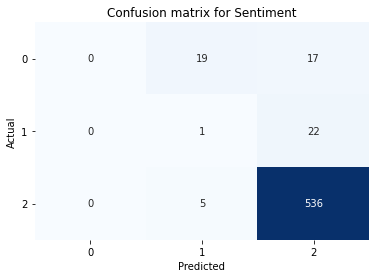

In [32]:
print('Test accuracy is {}'.format(accuracy_score(test['sentiment'], test['sentiment_pred'])))
print('Classification report:')
print(classification_report(test['sentiment'], test['sentiment_pred']))

# plot confusion matrix
cm = confusion_matrix(test['sentiment'], test['sentiment_pred'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", 
        title="Confusion matrix for Sentiment")
plt.yticks(rotation=0)

We achieved an accuracy of 89.5% on our test dataset.

This is quite a good result given that we only used 2000 labelled dataset for our training, and also given the imbalance within our data. 

# Predict on Full Data

In [33]:
full = pd.read_csv('full_reviews.csv')
full.head()

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence
0,24210,4752817,32899279,2015-05-23,30809209,Kris,The place was beautiful and looks just like in...,The washerdryer was a nice bonus We felt very...
1,23410,8035212,54542442,2015-11-21,30067460,Christopher,This place was really great. First airbnb stay...,Kitchen is full of utensils and things one wi...
2,61755,573942,45248491,2015-09-01,33801257,Wim,The vintage room was a small cramp room next t...,There is a wonderful bathroom but there are a...
3,18364,26116,2980215,2012-11-27,1618109,Adam,"We spent four nights in Jamilah's place, and e...",We spent four nights in Jamilahs place and eve...
4,56277,6927016,56227463,2015-12-10,32212189,William,Super cute and funky little apartment. The art...,Super cute and funky little apartment


Due to the large size of the reviews dataset, we will show our predictions using only 10k data points.

In [35]:
full = full[0:10000]

In [37]:
full_input = bert_encode(full.sentence.values, tokenizer, max_len=max_len)
print('Encoding finished!')
model.load_weights('model.h5')
full_pred = model.predict(full_input)
print('Prediction finished!')

list2 = full_pred.tolist()
full['label_pred'] = list2
full['sentiment_pred'] = full['label_pred'].apply(lambda x: encode(x))
full.head()

Encoding finished!
Prediction finished!


,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,sentence,label_pred,sentiment_pred
0,24210,4752817,32899279,2015-05-23,30809209,Kris,The place was beautiful and looks just like in...,The washerdryer was a nice bonus We felt very...,"[0.00018585320503916591, 0.0001690114440862089...",1
1,23410,8035212,54542442,2015-11-21,30067460,Christopher,This place was really great. First airbnb stay...,Kitchen is full of utensils and things one wi...,"[0.0006380588747560978, 8.068673923844472e-05,...",1
2,61755,573942,45248491,2015-09-01,33801257,Wim,The vintage room was a small cramp room next t...,There is a wonderful bathroom but there are a...,"[0.4194706976413727, 0.0019290930358693004, 0....",1
3,18364,26116,2980215,2012-11-27,1618109,Adam,"We spent four nights in Jamilah's place, and e...",We spent four nights in Jamilahs place and eve...,"[0.0002820818335749209, 0.00010626824951032177...",1
4,56277,6927016,56227463,2015-12-10,32212189,William,Super cute and funky little apartment. The art...,Super cute and funky little apartment,"[0.000503342307638377, 0.00019630053429864347,...",1


In [38]:
full.to_csv('final_reviews.csv')

# Visualize results

In [39]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [51]:
pos = full[full['sentiment_pred'] == 1]
pos.shape

(9640, 10)

In [52]:
neg = full[full['sentiment_pred'] == 0]
neg.shape

(360, 10)

## positive word cloud

In [63]:
text = pos.sentence.tolist()
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS,width = 2000, height = 2000,
                      collocations=True,background_color='salmon', 
                      colormap='Pastel1').generate(text)

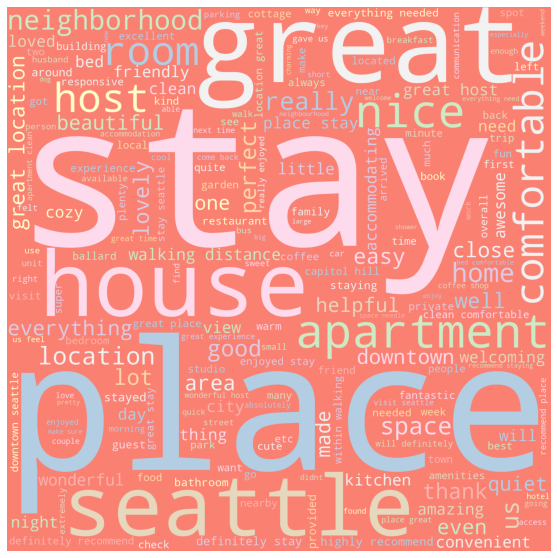

In [68]:
#plot the wordcloud object
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(wordcloud)

## negative word cloud

In [69]:
text = neg.sentence.tolist()
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS,width = 2000, height = 2000,
                      collocations=True).generate(text)

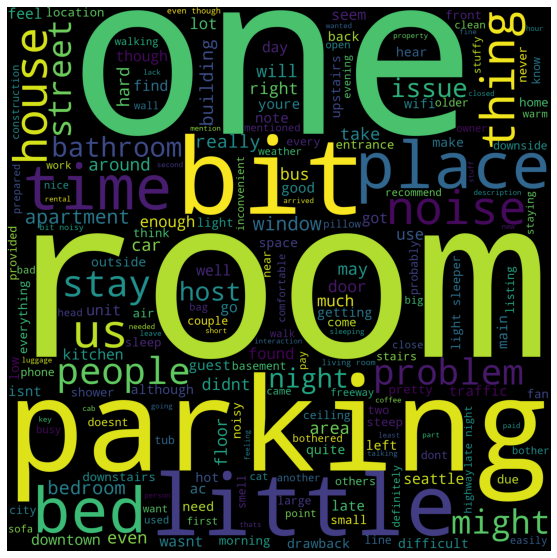

In [70]:
#plot the wordcloud object
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(wordcloud)

- As shown, the word clouds contain the most common words for positive and negative reviews.

- To help the owners improve their accomodations, these negative reviews can be sieved out and used to notify the owners on how to improve to attract more customers.